# Module 9: Unguided corefinement for MnTe

MnTe is an antiferromagnet with a Neel temperature of 307 K. A file containing neutron PDF data collected on the NOMAD instrument at 320 K is found in the files directory (NOM_MnTe_320K.gr), along with a CIF file for the atomic structure of MnTe. Your task is to perform a corefinement (either simultaneous or iterative) of the atomic and magnetic structure of MnTe at 320 K (MnTe_hex.cif). You may want to start by looking up MnTe on MAGNDATA to help you think about how to define the magnetic structure. Keep in mind that this measurement was done in the paramagnetic state, so the magnetic correlation length will be finite.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from diffpy.mpdf import *
from diffpy.structure.parsers import getParser
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.srfit.fitbase import FitRecipe, FitResults
from diffpy.srfit.fitbase import Profile, FitContribution
from diffpy.structure import loadStructure

%matplotlib widget 
# or try %matplotlib notebook

In [3]:
struc = loadStructure('files/MnTe_hex.cif')
print(struc)

lattice=Lattice(a=4.193, b=4.193, c=6.752, alpha=90, beta=90, gamma=120)
Te   0.333333 0.666667 0.250000 1.0000
Te   0.666667 0.333333 0.750000 1.0000
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.000000 0.500000 1.0000


In [6]:
def combined_fit(dataFile, structureFile, rmin=1.5, rmax=20.0, method='corefinement'):
    """
    method = 'corefinement': true simultaneous corefinement of atomic and magnetic parameters
    method = 'toggle': iterative fit that toggles between atomic and magnetic parameters
    """
    # load in the starting structure
    pcif = getParser('cif')
    struc = pcif.parseFile(structureFile)

    # prepare profile object with experimental data
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(dataFile)
    profile.loadParsedData(parser)
    
    # define qdamp and qbroad (determined previously from calibration fits)
    qdamp = 0.025
    qbroad = 0.025

    # set up calculation range for the PDF simulation
    rstep = 0.01
    profile.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)

    # prepare the function that calculates the atomic PDF
    nucpdf = PDFGenerator("nucpdf") # this will calculate the atomic PDF
    nucpdf.setStructure(struc)
    nucpdf.setProfile(profile)

    # prepare a FitContribution object that will include the atomic and magnetic PDF
    totpdf = FitContribution('totpdf')
    totpdf.addProfileGenerator(nucpdf) # we'll add the mPDF later
    totpdf.setProfile(profile)

    # set up the MagSpecies
    mspec = MagSpecies(struc=struc,rmaxAtoms=rmax,ffparamkey='Mn2')
    mspec.strucIdxs = [2, 3] # determined from previous inspection of the unit cell
    mspec.basisvecs = np.array([1, -1, 0]) # any vector perpendicular to the c axis will be fine
    mspec.kvecs = np.array([0, 0, 1]) # this gives the desired AF structure for this choice of unit cell

    # set up the MagStructure
    mstruc = MagStructure(rmaxAtoms=rmax)
    mstruc.loadSpecies(mspec)
    mstruc.makeAll() ### populates the spin and atom arrays

    # create the MPDFcalculator for MnO
    mc = MPDFcalculator(magstruc=mstruc,qdamp=qdamp,rmax=rmax,rmin=rmin)

    # Define an mPDF function that will be added to the total PDF calculator
    def mpdf(ordscale, parascale, xi):
        """
        ordscale = ordered scale factor (mc.ordScale)
        parascale = paramagnetic scale factor (mc.paraScale)
        xi = correlation length (mstruc.corrLength)
        """
        mc.ordScale = ordscale
        mc.paraScale = parascale
        mstruc.corrLength = xi
        mstruc.makeAll() # regenerate the spins in each function call to use the latest structural parameters
        # return the "unnormalized" mPDF
        rcalc, fcalc, dcalc = mc.calc(both=True)
        return dcalc

    # add mPDF to the FitContribution
    totpdf.registerFunction(mpdf)
    totpdf.setEquation("nucscale * nucpdf + mpdf(ordscale,parascale,xi)")

    # Make magnetic PDF depend on any changes to the atomic structure.
    # A structure change will now trigger reevaluation of the mPDF.
    nucpdf.phase.addObserver(totpdf.ordscale.notify)

    # set up the FitRecipe
    fit = FitRecipe()
    fit.addContribution(totpdf)

    # fix qdamp and qbroad based on prior information
    fit.addVar(nucpdf.qdamp, qdamp, fixed=True, name='qdamp')
    fit.addVar(nucpdf.qbroad, qbroad, fixed=True, name='qbroad')

    # Configure the fit variables and give them to the recipe.
    from diffpy.srfit.structure import constrainAsSpaceGroup
    sgpars = constrainAsSpaceGroup(nucpdf.phase, pcif.spacegroup.short_name) # this loads in the space group symmetry constraints

    for par in sgpars.latpars:
        fit.addVar(par,tag='LatPars') # we will use these tags later
    for par in sgpars.adppars:
        fit.addVar(par, value=0.003, tag='ADPs')

    # note that there are no positional degrees of freedom (i.e. xyz parameters) for this structure
        
    fit.addVar(totpdf.nucscale, 0.05, name='nucscale')
    fit.addVar(nucpdf.delta1, value=1.0, name='delta1')

    # mPDF parameters
    fit.addVar(totpdf.parascale, 0, tag='Mag')
    rstPs = fit.restrain(totpdf.parascale,lb=0,ub=100.0,sig=0.0001) # set reasonable bounds
    fit.addVar(totpdf.ordscale, 0.0, tag='Mag')
    rstOs = fit.restrain(totpdf.ordscale,lb=0,ub=100.0,sig=0.0001)
    fit.addVar(totpdf.xi, 10, tag='Mag')
    rstXi = fit.restrain(totpdf.xi,lb=0.5,ub=1000.0,sig=0.0001)

    # Turn off printout of iteration number.
    fit.clearFitHooks()
    fit.fix('all')

    # Now we set up either an iterative fit or a true corefinement
    if method == 'corefinement':
        # Our approach will be to introduce the parameters one group at a time.
        # We begin with the structural parameters and then add the magnetic parameters.
        # start with scale factor and lattice parameters
        fit.free('nucscale')
        fit.free('LatPars') # we use the tag LatPars to free all the lattice parameters
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # skipping xyz parameters because there are none in this symmetry

        # add the ADps
        fit.free('ADPs')
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # add delta1
        fit.free('delta1')
        print(fit.names)
        least_squares(fit.residual,fit.values)

        # add the magnetic parameters
        fit.free('Mag')
        print(fit.names)
        least_squares(fit.residual,fit.values) # this is now refining all variables jointly

    if method == 'toggle':
        # In this approach, we toggle between just structural parameters and just magnetic parameters.
        # We iterate back and forth three times (usually sufficient to ensure complete convergence).
        numIterations = 3 # number of times to toggle between atomic and magnetic parameters
        for i in range(numIterations):
            # start with scale factor and lattice parameters
            fit.free('nucscale')
            fit.free('LatPars') # we use the tag LatPars to free all the lattice parameters
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # skipping xyz parameters because there are none in this symmetry

            # add the ADps
            fit.free('ADPs')
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # add delta1
            fit.free('delta1')
            print(fit.names)
            least_squares(fit.residual,fit.values)

            # now fix all the atomic parameters and free the magnetic parameters
            fit.fix('all')

            fit.free('Mag')
            print(fit.names)
            magOpt = least_squares(fit.residual,fit.values)
            
            if i < (numIterations - 1):
                fit.fix('all') # fix all the parameters and start the loop again

    # Display results and plot the fit
    r = fit.totpdf.profile.x
    gobs = fit.totpdf.profile.y

    # Get the calculated PDF and compute the difference between the calculated and
    # measured PDF
    totcalc = fit.totpdf.evaluate() # calculated combined atomic and magnetic PDF
    magcalc = mpdf(fit.ordscale.value,fit.parascale.value,fit.xi.value) # just mPDF
    nuccalc = totcalc - magcalc # just atomic PDF
    baseline = 1.2 * gobs.min()
    nucdiff = gobs - nuccalc
    totdiff = gobs - totcalc # total fit residual
    results = FitResults(fit)
    print('Rw = '+str(results.rw))

    # Plot the structural refinement
    ax=plt.figure().add_subplot(111)
    ax.plot(r, gobs, 'bo', label="G(r) data",markerfacecolor='none', markeredgecolor='b')
    ax.plot(r, totcalc, 'r-', lw=1.5, label="Total fit")
    ax.plot(r, nucdiff + baseline, marker='o',mec='Gray',mfc='None')
    ax.plot(r, magcalc + baseline, marker='None',color='Blue',lw=2, label='mPDF fit')
    ax.plot(r, totdiff+1.4*baseline, 'g-')
    ax.plot(r, np.zeros_like(r) + 1.4*baseline, 'k:')


    ax.set_xlabel(r"r ($\mathdefault{\AA}$)")
    ax.set_ylabel(r"G ($\mathdefault{\AA^{-2}}$)")
    plt.legend()

    plt.show()
    
    return fit

['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale', 'delta1']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale', 'delta1', 'parascale', 'ordscale', 'xi']
Rw = 0.10178928363803086


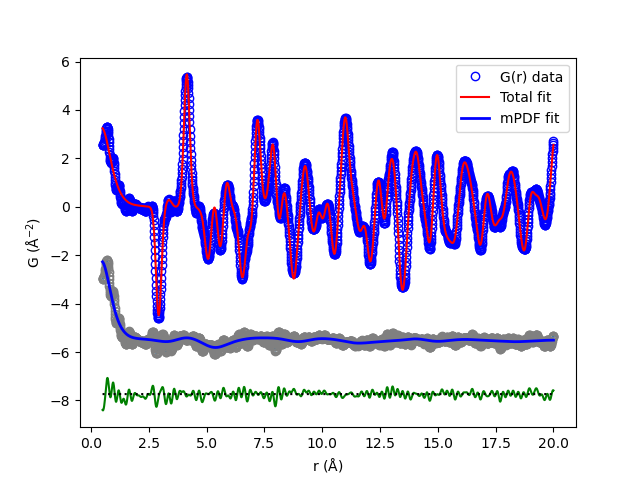

('a', np.float64(4.152253522661363))
('c', np.float64(6.724216473332997))
('U11_0', np.float64(0.010079086213721103))
('U33_0', np.float64(0.013586727825711065))
('U11_2', np.float64(0.017094393347053295))
('U33_2', np.float64(0.016328713923910214))
('nucscale', np.float64(0.02794294777742287))
('delta1', np.float64(1.5006175952355025))
('parascale', np.float64(11.604048144813607))
('ordscale', np.float64(0.8048577504505185))
('xi', np.float64(8.260152839211068))


In [7]:
dataFile = 'files/NOM_MnTe_320K.gr'
structureFile = 'files/MnTe_hex.cif'

fit = combined_fit(dataFile, structureFile, rmin=0.5, rmax=20, method='corefinement')

# print out the refined parameter values
for item in zip(fit.names, fit.values):
    print(item)

['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale', 'delta1']
['parascale', 'ordscale', 'xi']
['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale', 'delta1']
['parascale', 'ordscale', 'xi']
['a', 'c', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale']
['a', 'c', 'U11_0', 'U33_0', 'U11_2', 'U33_2', 'nucscale', 'delta1']
['parascale', 'ordscale', 'xi']
Rw = 0.10178935096284546


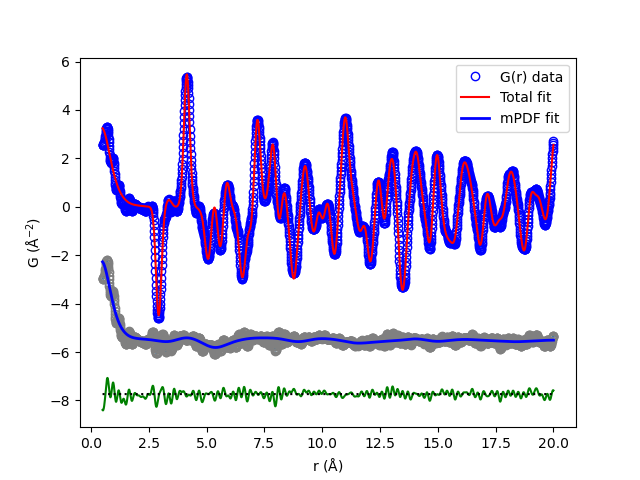

('parascale', np.float64(11.604224068370565))
('ordscale', np.float64(0.8040298149748609))
('xi', np.float64(8.263431228557897))


In [8]:
fit = combined_fit(dataFile, structureFile, rmin=0.5, rmax=20, method='toggle')

# print out the refined parameter values
# note we print out fit.fixednames and fit.fixedvalues because the toggling
# routine ends up with all variabales fixed after completing the fit
for item in zip(fit.names, fit.values):
    print(item)

In [9]:
plt.close('all')